# Data: SMILES strings

SMILES (Simplified Molecular-Input Line-Entry System) will be used as dataset. The key idea is to use a text representation of the molecules to be compatible with NLP models. Each SMILES string is a modecule which consists of atoms. There are publicly-available datasets that could be used like [ZINC](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00559), [ChEMBL](https://www.ebi.ac.uk/chembl/) and [PubChem](https://pubchem.ncbi.nlm.nih.gov/) which contain millions of SMILES. 

![SMILES generation algorithm for Ciprofloxacin: break cycles, then write as branches off a main backbone](https://upload.wikimedia.org/wikipedia/commons/0/00/SMILES.png) 

SMILES generation algorithm for Ciprofloxacin: break cycles, then write as branches off a main backbone [[source: https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system]](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)

In [ ]:
%%capture
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
sns.set()
%matplotlib inline

In [ ]:
# !wget ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_23/chembl_23_chemreps.txt.gz
# !gunzip chembl_23_chemreps.txt.gz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_table('/content/drive/My Drive/Colab Notebooks/chembl_23_chemreps.txt')
print(f'We have {len(data)} canonical SMILES.')
data.head()

We have 1727112 canonical SMILES.


,chembl_id,canonical_smiles,standard_inchi,standard_inchi_key
0,CHEMBL153534,Cc1cc(cn1C)c2csc(N=C(N)N)n2,InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10...,MFRNFCWYPYSFQQ-UHFFFAOYSA-N
1,CHEMBL440060,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,InChI=1S/C123H212N44O34S/c1-19-63(12)96(164-11...,RSEQNZQKBMRQNM-VRGFNVLHSA-N
2,CHEMBL440245,CCCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN...,InChI=1S/C160H268N50O41/c1-23-27-41-95-134(228...,FTKBTEIKPOYCEX-OZSLQWTKSA-N
3,CHEMBL440249,CC(C)C[C@@H]1NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](N...,InChI=1S/C124H154ClN21O39/c1-57(2)48-81-112(17...,UYSXXKGACMHPIM-KFGDMSGDSA-N
4,CHEMBL405398,Brc1cccc(Nc2ncnc3ccncc23)c1NCCN4CCOCC4,InChI=1S/C19H21BrN6O/c20-15-2-1-3-17(18(15)22-...,VDSXZXJEWIWBCG-UHFFFAOYSA-N


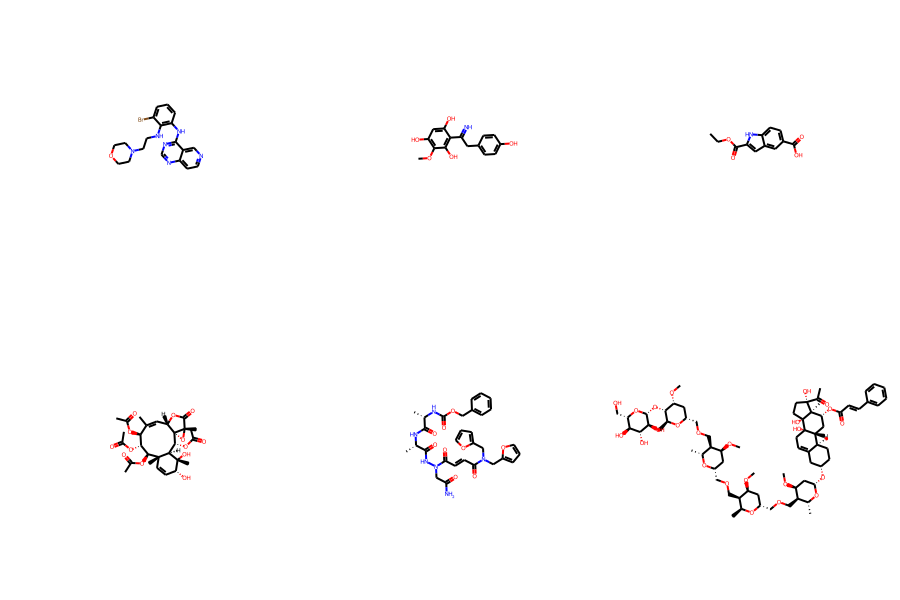

In [ ]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
MolsToGridImage(mols = list(map(MolFromSmiles,data.loc[4:9,'canonical_smiles'])),
                maxMols=6,molsPerRow=3,subImgSize=(300,300))

**Tokenization:** 
In the literature exists different approaches to tokenize the SMILES strings. We will use the character-level tokenization with some additional features. 
Each character will be a token and (1) 'Cl','Br' are two-character tokens, (2) the characters that are encoded between brackets; considered as tokens (e.g. '[nH]', '[C@@H]', etc.). This is considered an atom-wise tokenization of the SMILES. Finally, we included the '[BOS]' begin of smiles token, the '[PAD]' padding token and the '[UNK]' unknown token. For example, the Chalcogran molecule: "CC[C@H](O1)CC[C@@]12CCCO2" is tokenized as: " 'C','C','[C@H]','(','O','1',')','C','C','[C@@]','1','2','C','C','C','O','2' ".


In [ ]:
def atom2vec(smile):
    # source: https://github.com/XinhaoLi74/SmilesPE
    """
    Tokenize a SMILES molecule at atom-level:
        (1) 'Br' and 'Cl' are two-character tokens
        (2) Symbols with bracket are considered as tokens
        (3) Rest sympols and letters considerd tokens
    """
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smile)]
    return tokens

# atom2vec(data['canonical_smiles'][66])

In [ ]:
data['vect_smiles'] = data["canonical_smiles"].apply(atom2vec)
SMILES_lengths = data["vect_smiles"].apply(len)

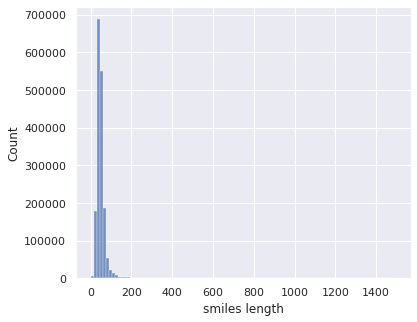

In [ ]:
plt.figure(figsize=(6,5))
ax = sns.histplot(SMILES_lengths, bins=100)
ax.set(xlabel='smiles length', ylabel='Count')
plt.show();

In [ ]:
print(f'We can see that only {np.mean(SMILES_lengths>200)*100 :.2f}% of the smiles from cheml23 have length greater than 200.')

We can see that only 0.57% of the smiles from cheml23 have length greater than 200.


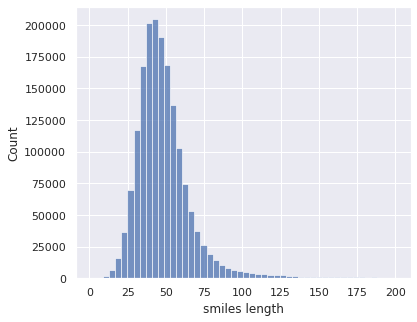

In [ ]:
plt.figure(figsize=(6,5))
ax = sns.histplot(SMILES_lengths[SMILES_lengths<=200], bins=50)
ax.set(xlabel='smiles length', ylabel='Count')
plt.show();

In [ ]:
# average length of SMILES strings
np.mean(SMILES_lengths[SMILES_lengths<=200])

48.566433468702286

In [ ]:
chembl = data[SMILES_lengths<=200]
chembl = chembl.drop(['standard_inchi', 'standard_inchi_key'], axis=1)
# chembl.to_csv('chembl23_sub200.csv', index=False)
print(f'We have {len(chembl)} canonical SMILES with length less than 200.')

We have 1717282 canonical SMILES with length less than 200.


In [ ]:
# #Move a file to another folder
# !mv /content/chembl23_sub200.csv /content/drive/My\ Drive/Colab\ Notebooks

In [ ]:
# subset of chembl23
# chembl = pd.read_csv('/content/drive/My Drive/Colab Notebooks/chembl23_sub200.csv')

In [ ]:
tokens = [c for s in chembl['vect_smiles'] for c in s]

from collections import Counter 
# count of each element in string  
res = Counter(tokens) 
print("We have", len(res),"different tokens.")

We have 274 different tokens.


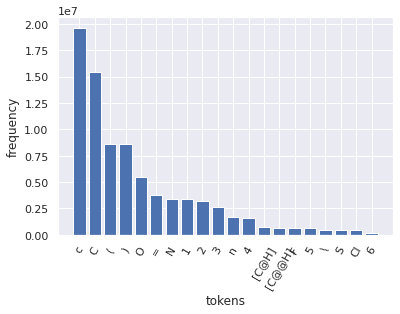

In [ ]:
freqN = res.most_common(20)
keys = [i[0] for i in freqN]
values = [i[1] for i in freqN]

# plt.figure(figsize=(10,5))
plt.figure(figsize=(6,4))
plt.bar(keys, values)
plt.xticks(rotation=60)
# plt.title("The 20 most common tokens")
plt.xlabel('tokens')
plt.ylabel('frequency')
plt.show();

# Lipophilicity

https://en.wikipedia.org/wiki/Lipophilicity

https://www.admescope.com/physicochemistry-and-binding/lipophilicity.html

The lipophilicity property refers to the ability of a molecule to dissolve in fat (oils, lipids). 

In [ ]:
# https://figshare.com/articles/Lipophilicity_Dataset_-_logD7_4_of_1_130_Compounds/5596750/1
! wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv

In [ ]:
df = pd.read_csv("/content/Lipophilicity.csv")
df.head()

In [ ]:
from rdkit import Chem
# Returns the canonical SMILES string for a molecule
df['canonical_smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),canonical=True) for smi in df['smiles']]

# save the df into .csv
# df.to_csv(r'/content/drive/My Drive/Colab Notebooks/Lipophi_canon.csv', index = False, header=True)

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Lipophi_canon.csv")
df.head()

,CMPD_CHEMBLID,exp,smiles,canonical_smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...


Display some SMILES for the Lipophilicity dataset.

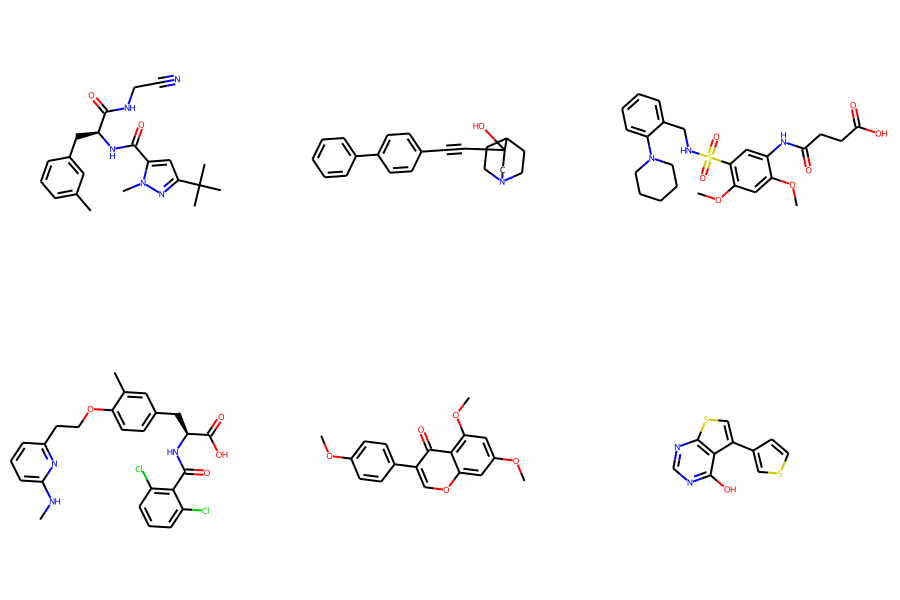

In [ ]:
MolsToGridImage(mols = list(map(MolFromSmiles,df.loc[4:9,'canonical_smiles'])),
                maxMols=6,molsPerRow=3,subImgSize=(300,300))

In [ ]:
df.rename(columns={'CMPD_CHEMBLID':'CMPD_CHEMBLID', "exp": "logD",
                   "smiles": "smiles","canonical_smiles":"SMILES"}, inplace=True)

In [ ]:
data = df.copy()

In [ ]:
data['vect_smiles'] = df["SMILES"].apply(atom2vec)
SMILES_lengths = data["vect_smiles"].apply(len)

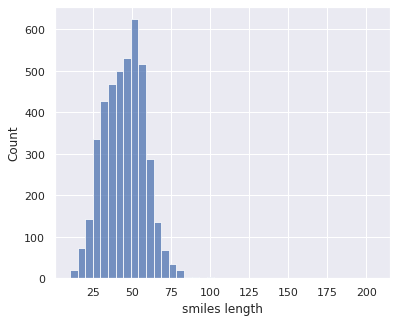

In [ ]:
plt.figure(figsize=(6,5))
ax = sns.histplot(SMILES_lengths, bins=40)
ax.set(xlabel='smiles length', ylabel='Count')
plt.show();

In [ ]:
tokens = [c for s in data['vect_smiles'] for c in s]

from collections import Counter 
# count of each element in string  
res = Counter(tokens) 
print("We have", len(res),"different tokens.")

We have 40 different tokens.


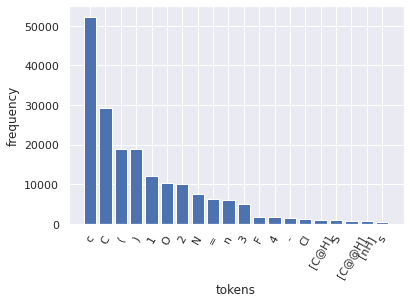

In [ ]:
freqN = res.most_common(20)
keys = [i[0] for i in freqN]
values = [i[1] for i in freqN]

plt.figure(figsize=(6,4))
plt.bar(keys, values)
plt.xticks(rotation=60)
plt.xlabel('tokens')
plt.ylabel('frequency')
plt.show();

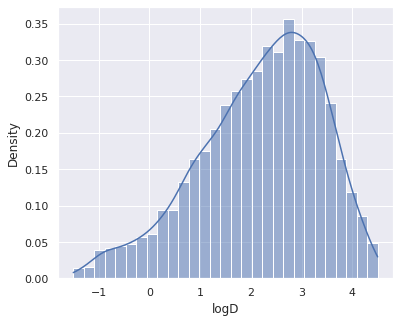

In [ ]:
# histogram and kde of the lipophilicity values
plt.figure(figsize=(6,5))
sns.histplot(data['logD'],kde=True,stat="density");

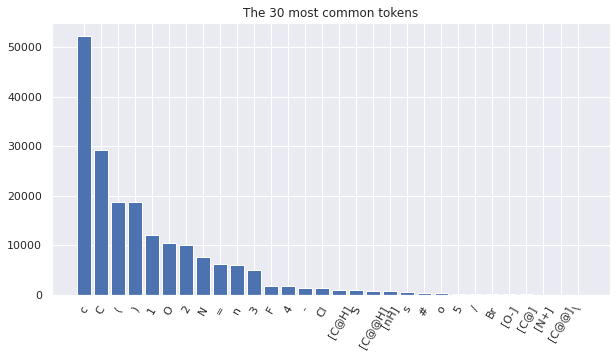

In [ ]:
freqN = res.most_common(30)
keys = [i[0] for i in freqN]
values = [i[1] for i in freqN]

plt.figure(figsize=(10,5))
plt.bar(keys, values)
plt.xticks(rotation=60)
plt.title("The 30 most common tokens")
plt.show();

# Data Augmentation

Example:

![https://media.arxiv-vanity.com/render-output/3772847/x1.png](https://media.arxiv-vanity.com/render-output/3772847/x1.png)


source: https://arxiv.org/abs/1703.07076 by Esben Jannik Bjerrum

In [ ]:
from rdkit import Chem
# code adapted from https://github.com/XinhaoLi74/MolPMoFiT/blob/master/notebooks/utils.py
# by Xinhao Li
def randomize_smiles(smiles):
    m = Chem.MolFromSmiles(smiles)
    ans = list(range(m.GetNumAtoms()))
    np.random.shuffle(ans)
    nm = Chem.RenumberAtoms(m,ans)
    return Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True, kekuleSmiles=False)

def smiles_augmentation(df, N_rounds):
    dist_aug = {"SMILES": [] ,'logD':[],'canonical':[]}

    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug['SMILES'].append(randomize_smiles(df.iloc[i].SMILES))
            # we will use Gaussian noise with sd=0.3
            dist_aug['logD'].append(df.iloc[i].logD + np.random.normal(loc=0.0, scale=0.3, size=1)[0])
            dist_aug['canonical'].append('no')

    df_aug = pd.DataFrame.from_dict(dist_aug)
    
    #merge with original df
    df = pd.concat([df, df_aug], sort=False).reset_index(drop=True)
    #shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    return pd.DataFrame.from_dict(df).drop_duplicates('SMILES')

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Lipophi_canon.csv")

df.rename(columns={'CMPD_CHEMBLID':'CMPD_CHEMBLID', "exp": "logD",
                   "smiles": "smiles","canonical_smiles":"SMILES"}, inplace=True)

df = df.drop(['CMPD_CHEMBLID', 'smiles'], axis=1)

df['canonical'] = 'yes'

In [ ]:
df_augment = smiles_augmentation(df, N_rounds=25)

In [ ]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
MolsToGridImage(mols = list(map(MolFromSmiles,data.loc[4:9,'canonical_smiles'])),
                maxMols=6,molsPerRow=3,subImgSize=(300,300))

# References:

[1] [Weininger D (1988) SMILES, a chemical language and information system. 1. Introduction to methodology and encoding rules. J Chem Inf Model 28:31–36. https ://doi.org/10.1021/ci000 57a005](https://pubs.acs.org/doi/10.1021/ci00057a005)

[2] [Li, Xinhao; Fourches, Denis (2020): SMILES Pair Encoding: A Data-Driven Substructure Tokenization Algorithm for Deep Learning. ChemRxiv. Preprint. https://doi.org/10.26434/chemrxiv.12339368.v1](https://chemrxiv.org/articles/SMILES_Pair_Encoding_A_Data-Driven_Substructure_Tokenization_Algorithm_for_Deep_Learning/12339368)

[3] [Li, X., Fourches, D. Inductive transfer learning for molecular activity prediction: Next-Gen QSAR Models with MolPMoFiT. J Cheminform 12, 27 (2020). https://doi.org/10.1186/s13321-020-00430-x](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00430-x)

[4] [The RDKit Documentation — The RDKit 2020.03.1 documentation. URLhttps://rdkit.org/docs/index.html.](https://rdkit.org/docs/index.html)

[4] [Bjerrum EJ (2017) SMILES enumeration as data augmentation for neural network modeling of molecules. http://arxiv .org/abs/1703.07076](https://arxiv.org/abs/1703.07076)